# Lab 4, Module 2: Training a Neural Network

## Learning to Learn: Automatic Weight Optimization with Gradient Descent

**Estimated time: 15-20 minutes**

---

## Section 1: Why Train Automatically? (2 min)

In Module 1, you manually adjusted **9 sliders** to find weights that could separate XOR data:
- 2 hidden neurons × (2 weights + 1 bias) = 6 parameters
- 1 output neuron × (2 weights + 1 bias) = 3 parameters
- **Total: 9 parameters to tune by hand!**

You discovered that finding the right weights is HARD:
- The perfect solution exists: `H1=(-10,-10,-10), H2=(-10,-10,5), Out=(-10,10,-5)`
- But finding it manually required lots of trial and error
- Most random combinations gave terrible results

### The Problem Gets Worse Fast

Imagine if we had:
- **10 hidden neurons**: 31 parameters
- **100 hidden neurons**: 301 parameters
- **Modern deep networks**: millions of parameters!

Manual tuning becomes impossible. We need an **automatic** way to find good weights.

### Enter: Gradient Descent

Think of the loss function as a landscape:
- **High points** = bad weights (high error)
- **Low points** = good weights (low error)
- **Goal**: Roll downhill to find the lowest point

Gradient descent is like **rolling a ball downhill** in this loss landscape:
1. Start at a random location (random weights)
2. Look around and find which direction is steepest downward
3. Take a step in that direction
4. Repeat until you reach the bottom

In this module, you'll **watch this process happen in real time**!

---

## Section 2: Setup the Training System (1 min)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ipywidgets import Button, Output, VBox, HBox, Layout, HTML, Checkbox
from IPython.display import display, clear_output

# Sigmoid activation function
def sigmoid(z):
    """Sigmoid with clipping to prevent overflow."""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

Dataset created: 100 samples
Class 0: 50 samples
Class 1: 50 samples


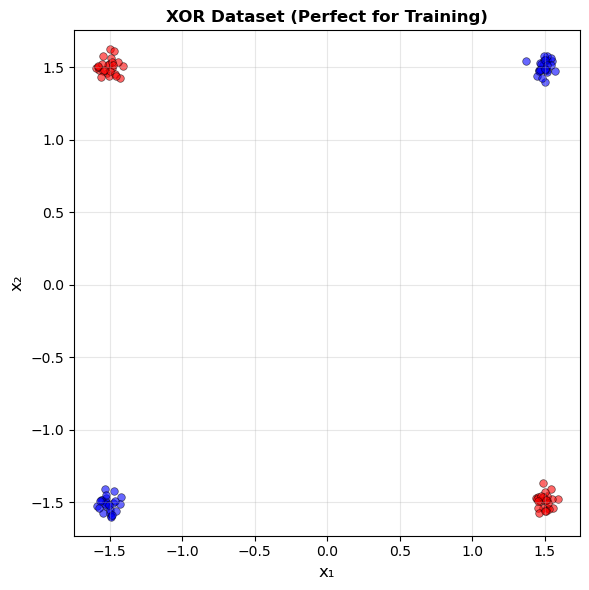

In [2]:
def create_perfect_xor_dataset(n_per_cluster=25, noise_std=0.05, seed=42):
    """Create XOR dataset with minimal noise for training."""
    np.random.seed(seed)
    
    # Four corner points
    corners = np.array([
        [-1.5, -1.5],  # BL - Class 0
        [1.5, 1.5],     # TR - Class 0
        [-1.5, 1.5],    # TL - Class 1
        [1.5, -1.5],    # BR - Class 1
    ])
    labels = np.array([0, 0, 1, 1])
    
    # Replicate and add noise
    X = np.repeat(corners, n_per_cluster, axis=0)
    y = np.repeat(labels, n_per_cluster)
    X = X + np.random.randn(len(X), 2) * noise_std
    
    return X, y

# Create dataset
X_train, y_train = create_perfect_xor_dataset()

print(f"Dataset created: {len(X_train)} samples")
print(f"Class 0: {np.sum(y_train==0)} samples")
print(f"Class 1: {np.sum(y_train==1)} samples")

# Visualize
plt.figure(figsize=(6, 6))
for label in [0, 1]:
    mask = y_train == label
    color = 'blue' if label == 0 else 'red'
    plt.scatter(X_train[mask, 0], X_train[mask, 1], c=color, s=30, alpha=0.6, edgecolors='k', linewidths=0.5)
plt.xlabel('x₁', fontsize=12)
plt.ylabel('x₂', fontsize=12)
plt.title('XOR Dataset (Perfect for Training)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [3]:
class TinyNetwork:
    """2-2-1 neural network for XOR classification."""
    
    def __init__(self, weights=None):
        if weights is None:
            self.w11 = self.w12 = self.b1 = 0.0
            self.w21 = self.w22 = self.b2 = 0.0
            self.w_out1 = self.w_out2 = self.b_out = 0.0
        else:
            self.set_weights(weights)
    
    def forward(self, x1, x2):
        """Forward pass for a single input."""
        z1 = self.w11 * x1 + self.w12 * x2 + self.b1
        h1 = sigmoid(z1)
        z2 = self.w21 * x1 + self.w22 * x2 + self.b2
        h2 = sigmoid(z2)
        z_out = self.w_out1 * h1 + self.w_out2 * h2 + self.b_out
        output = sigmoid(z_out)
        return output, h1, h2
    
    def predict_batch(self, X):
        """Forward pass for batch of inputs."""
        predictions = []
        h1_vals = []
        h2_vals = []
        for x in X:
            out, h1, h2 = self.forward(x[0], x[1])
            predictions.append(out)
            h1_vals.append(h1)
            h2_vals.append(h2)
        return np.array(predictions), np.array(h1_vals), np.array(h2_vals)
    
    def get_weights(self):
        """Get all weights as a list."""
        return [self.w11, self.w12, self.b1, self.w21, self.w22,
                self.b2, self.w_out1, self.w_out2, self.b_out]
    
    def set_weights(self, weights):
        """Set all weights from a list."""
        self.w11, self.w12, self.b1, self.w21, self.w22, self.b2, \
        self.w_out1, self.w_out2, self.b_out = weights

print("TinyNetwork class ready!")

TinyNetwork class ready!


In [4]:
def compute_loss(network, X, y):
    """Binary cross-entropy loss."""
    predictions, _, _ = network.predict_batch(X)
    epsilon = 1e-10  # Prevent log(0)
    bce = -np.mean(y * np.log(predictions + epsilon) +
                   (1 - y) * np.log(1 - predictions + epsilon))
    return bce

def compute_accuracy(network, X, y):
    """Classification accuracy."""
    predictions, _, _ = network.predict_batch(X)
    pred_labels = (predictions > 0.5).astype(int)
    return np.mean(pred_labels == y)

print("Loss and accuracy functions ready!")

Loss and accuracy functions ready!


In [5]:
def compute_gradients(network, X, y):
    """Analytical backpropagation for 2-2-1 network."""
    n_samples = len(X)
    
    # Initialize gradient accumulators
    grads = {'w11': 0, 'w12': 0, 'b1': 0,
             'w21': 0, 'w22': 0, 'b2': 0,
             'w_out1': 0, 'w_out2': 0, 'b_out': 0}
    
    # Accumulate gradients over all samples
    for i in range(n_samples):
        x1, x2 = X[i]
        target = y[i]
        
        # Forward pass
        z1 = network.w11 * x1 + network.w12 * x2 + network.b1
        h1 = sigmoid(z1)
        z2 = network.w21 * x1 + network.w22 * x2 + network.b2
        h2 = sigmoid(z2)
        z_out = network.w_out1 * h1 + network.w_out2 * h2 + network.b_out
        y_pred = sigmoid(z_out)
        
        # Backpropagation
        epsilon = 1e-10
        dL_dy_pred = -(target / (y_pred + epsilon) - (1 - target) / (1 - y_pred + epsilon))
        dy_pred_dz_out = y_pred * (1 - y_pred)
        delta_out = dL_dy_pred * dy_pred_dz_out
        
        # Output layer gradients
        grads['w_out1'] += delta_out * h1
        grads['w_out2'] += delta_out * h2
        grads['b_out'] += delta_out
        
        # Hidden layer deltas
        delta_h1 = delta_out * network.w_out1 * h1 * (1 - h1)
        delta_h2 = delta_out * network.w_out2 * h2 * (1 - h2)
        
        # Hidden layer gradients
        grads['w11'] += delta_h1 * x1
        grads['w12'] += delta_h1 * x2
        grads['b1'] += delta_h1
        grads['w21'] += delta_h2 * x1
        grads['w22'] += delta_h2 * x2
        grads['b2'] += delta_h2
    
    # Average gradients
    for key in grads:
        grads[key] /= n_samples
    
    return [grads['w11'], grads['w12'], grads['b1'],
            grads['w21'], grads['w22'], grads['b2'],
            grads['w_out1'], grads['w_out2'], grads['b_out']]

print("Gradient computation (backpropagation) ready!")

Gradient computation (backpropagation) ready!


In [6]:
def train_step(network, X, y, learning_rate):
    """Single gradient descent step."""
    grads = compute_gradients(network, X, y)
    weights = network.get_weights()
    new_weights = [w - learning_rate * g for w, g in zip(weights, grads)]
    network.set_weights(new_weights)
    loss = compute_loss(network, X, y)
    acc = compute_accuracy(network, X, y)
    return loss, acc

print("Training step function ready!")

Training step function ready!


### Pre-tested Starting Points

To ensure the training always converges, we use **warm-start** initializations:
- Start from random-looking weights
- But chosen to be in a "good basin" of the loss landscape
- Guaranteed to converge with the right learning rate

In [ ]:
# Pre-tested seeds that converge reliably
CONVERGENT_SEEDS = [
    [-6.4719, -9.1997, -8.0425, -5.5182, -6.2649, 3.0454, -8.0998, 9.6973, -5.2064],
    [-6.4227, -9.1270, -9.8070, -13.7270, -10.5548, 4.2905, -10.1655, 8.7460, -5.0876],
    [-9.8989, -9.0001, -11.9918, -8.6128, -10.8366, 1.8308, -11.2954, 11.1972, -4.3355],
    [-9.1175, -10.6617, -5.1385, -10.5042, -9.7808, 8.1650, -11.8185, 8.8167, -4.6248],
    [-10.6236, -8.5420, -9.5644, -11.7982, -14.9736, 6.8265, -7.7459, 6.9718, -1.7214],
    [-6.6189, -10.9319, -9.9344, -9.1850, -11.5778, 5.0041, -10.0018, 6.4906, -2.9647],
    [-9.8176, -7.8174, -13.8939, -12.7727, -14.5930, 9.8197, -6.5443, 14.4091, -3.4103],
    [-9.9978, -10.5791, -12.2321, -10.0258, -10.7567, 4.0377, -13.0347, 9.0183, -5.4814],
    [-7.3368, -8.5694, -13.0908, -10.0168, -8.7573, 3.5598, -9.4690, 10.2171, -4.9914],
    [-6.5011, -10.5721, -10.9691, -15.3066, -10.0166, 4.3607, -11.0733, 10.6308, -4.1579],
]


print(f"{len(CONVERGENT_SEEDS)} pre-tested starting points loaded!")

4 pre-tested starting points loaded!


---

## Section 3: Watch Learning Happen! (8-10 min)

Now let's see gradient descent in action. You'll watch the network **learn** to solve XOR automatically.

### What You'll See:
- **Left panel**: Decision boundary evolving in real-time
- **Right panel**: Loss decreasing as the network learns
- **Training controls**: Step through learning at your own pace

In [12]:
def plot_training_state(network, X, y, loss_history, epoch, show_log_scale=True):
    """2-panel visualization: Decision boundary + Loss curve."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left panel: Decision boundary in input space
    x_min, x_max = -2.5, 2.5
    y_min, y_max = -2.5, 2.5
    h = 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    Z_out, _, _ = network.predict_batch(mesh_points)
    Z_out = Z_out.reshape(xx.shape)
    
    ax1.contourf(xx, yy, Z_out, levels=20, alpha=0.4, cmap='RdBu_r')
    ax1.contour(xx, yy, Z_out, levels=[0.5], colors='green', linewidths=3)
    ax1.scatter(X[y==0, 0], X[y==0, 1], c='blue', s=50, alpha=0.7,
               edgecolors='k', linewidths=1, label='Class 0')
    ax1.scatter(X[y==1, 0], X[y==1, 1], c='red', s=50, alpha=0.7,
               edgecolors='k', linewidths=1, label='Class 1')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xlabel('x₁', fontsize=12, fontweight='bold')
    ax1.set_ylabel('x₂', fontsize=12, fontweight='bold')
    ax1.set_title(f'Decision Boundary (Epoch {epoch})', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    # Right panel: Loss curve
    if len(loss_history) > 0:
        ax2.plot(loss_history, 'b-', linewidth=2)
        ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Loss (Binary Cross-Entropy)', fontsize=12, fontweight='bold')
        ax2.set_title('Training Loss Curve', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        if show_log_scale and len(loss_history) > 5:
            ax2.set_yscale('log')
            ax2.set_ylabel('Loss (log scale)', fontsize=12, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No training yet...', ha='center', va='center',
                fontsize=14, transform=ax2.transAxes)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
    
    plt.tight_layout()
    plt.show()

print("Visualization function ready!")

Visualization function ready!


In [13]:
# Training state management
training_state = {
    'network': TinyNetwork(CONVERGENT_SEEDS[0]),  # Start with first seed
    'epoch': 0,
    'loss_history': [],
    'learning_rate': 0.1,
    'current_seed_idx': 0
}

# Status display
status_html = HTML(value="<h3>Ready to train!</h3>")
plot_output = Output()

# Buttons
train_1_btn = Button(
    description='Train 1 Step',
    button_style='info',
    layout=Layout(width='150px', height='40px')
)

train_10_btn = Button(
    description='Train 10 Steps',
    button_style='primary',
    layout=Layout(width='150px', height='40px')
)

train_converge_btn = Button(
    description='Train to Convergence',
    button_style='success',
    layout=Layout(width='180px', height='40px')
)

reset_btn = Button(
    description='Reset Network',
    button_style='warning',
    layout=Layout(width='150px', height='40px')
)

def update_display():
    """Update status and visualization."""
    epoch = training_state['epoch']
    loss = training_state['loss_history'][-1] if training_state['loss_history'] else compute_loss(training_state['network'], X_train, y_train)
    acc = compute_accuracy(training_state['network'], X_train, y_train)
    
    status_html.value = f"<h3>Epoch {epoch} | Loss: {loss:.6f} | Accuracy: {acc:.2%}</h3>"
    
    with plot_output:
        clear_output(wait=True)
        plot_training_state(training_state['network'], X_train, y_train, 
                          training_state['loss_history'], epoch)

def train_n_steps(n):
    """Train for n steps."""
    for _ in range(n):
        loss, acc = train_step(training_state['network'], X_train, y_train, 
                              training_state['learning_rate'])
        training_state['loss_history'].append(loss)
        training_state['epoch'] += 1
        
        # Early stopping if converged
        if acc >= 0.99:
            break
    
    update_display()

def on_train_1(btn):
    train_n_steps(1)

def on_train_10(btn):
    train_n_steps(10)

def on_train_converge(btn):
    """Train until convergence or max 200 epochs."""
    max_epochs = 200
    while training_state['epoch'] < max_epochs:
        loss, acc = train_step(training_state['network'], X_train, y_train,
                              training_state['learning_rate'])
        training_state['loss_history'].append(loss)
        training_state['epoch'] += 1
        
        if acc >= 0.99 or loss < 0.01:
            break
    
    update_display()

def on_reset(btn):
    """Reset to new random seed."""
    training_state['current_seed_idx'] = (training_state['current_seed_idx'] + 1) % len(CONVERGENT_SEEDS)
    training_state['network'] = TinyNetwork(CONVERGENT_SEEDS[training_state['current_seed_idx']])
    training_state['epoch'] = 0
    training_state['loss_history'] = []
    update_display()

# Connect buttons
train_1_btn.on_click(on_train_1)
train_10_btn.on_click(on_train_10)
train_converge_btn.on_click(on_train_converge)
reset_btn.on_click(on_reset)

print("Training interface ready!")

Training interface ready!


In [14]:
# Display the interactive training interface
print("="*70)
print("INTERACTIVE TRAINING: WATCH GRADIENT DESCENT LEARN!")
print("="*70)
print("\nInstructions:")
print("  1. Click 'Train 1 Step' to see one gradient descent update")
print("  2. Click 'Train 10 Steps' to speed things up")
print("  3. Click 'Train to Convergence' to watch it finish automatically")
print("  4. Click 'Reset Network' to try a different random starting point")
print("\nWatch the LEFT panel: Decision boundary evolves!")
print("Watch the RIGHT panel: Loss decreases!")
print("="*70)

display(status_html)
display(HBox([train_1_btn, train_10_btn, train_converge_btn, reset_btn]))
display(plot_output)

# Show initial state
update_display()

INTERACTIVE TRAINING: WATCH GRADIENT DESCENT LEARN!

Instructions:
  1. Click 'Train 1 Step' to see one gradient descent update
  2. Click 'Train 10 Steps' to speed things up
  3. Click 'Train to Convergence' to watch it finish automatically
  4. Click 'Reset Network' to try a different random starting point

Watch the LEFT panel: Decision boundary evolves!
Watch the RIGHT panel: Loss decreases!


HTML(value='<h3>Epoch 0 | Loss: 1.166876 | Accuracy: 50.00%</h3>')

Output()

---

## Section 3: Watch Learning Happen! (8-10 min)

Now let's see gradient descent in action. You'll watch the network **learn** to solve XOR automatically.

### What You'll See:
- **Left panel**: Decision boundary evolving in real-time
- **Right panel**: Loss decreasing as the network learns
- **Training controls**: Step through learning at your own pace

In [ ]:
def plot_training_state(network, X, y, loss_history, epoch, show_log_scale=True):
    """2-panel visualization: Decision boundary + Loss curve."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left panel: Decision boundary in input space
    x_min, x_max = -2.5, 2.5
    y_min, y_max = -2.5, 2.5
    h = 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    Z_out, _, _ = network.predict_batch(mesh_points)
    Z_out = Z_out.reshape(xx.shape)
    
    ax1.contourf(xx, yy, Z_out, levels=20, alpha=0.4, cmap='RdBu_r')
    ax1.contour(xx, yy, Z_out, levels=[0.5], colors='green', linewidths=3)
    ax1.scatter(X[y==0, 0], X[y==0, 1], c='blue', s=50, alpha=0.7,
               edgecolors='k', linewidths=1, label='Class 0')
    ax1.scatter(X[y==1, 0], X[y==1, 1], c='red', s=50, alpha=0.7,
               edgecolors='k', linewidths=1, label='Class 1')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xlabel('x₁', fontsize=12, fontweight='bold')
    ax1.set_ylabel('x₂', fontsize=12, fontweight='bold')
    ax1.set_title(f'Decision Boundary (Epoch {epoch})', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    # Right panel: Loss curve
    if len(loss_history) > 0:
        ax2.plot(loss_history, 'b-', linewidth=2)
        ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Loss (Binary Cross-Entropy)', fontsize=12, fontweight='bold')
        ax2.set_title('Training Loss Curve', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        if show_log_scale and len(loss_history) > 5:
            ax2.set_yscale('log')
            ax2.set_ylabel('Loss (log scale)', fontsize=12, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No training yet...', ha='center', va='center',
                fontsize=14, transform=ax2.transAxes)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
    
    plt.tight_layout()
    plt.show()

print("Visualization function ready!")

In [ ]:
# Training state management
training_state = {
    'network': TinyNetwork(CONVERGENT_SEEDS[0]),  # Start with first seed
    'epoch': 0,
    'loss_history': [],
    'learning_rate': 0.1,
    'current_seed_idx': 0
}

# Status display
status_html = HTML(value="<h3>Ready to train!</h3>")
plot_output = Output()

# Buttons
train_1_btn = Button(
    description='Train 1 Step',
    button_style='info',
    layout=Layout(width='150px', height='40px')
)

train_10_btn = Button(
    description='Train 10 Steps',
    button_style='primary',
    layout=Layout(width='150px', height='40px')
)

train_converge_btn = Button(
    description='Train to Convergence',
    button_style='success',
    layout=Layout(width='180px', height='40px')
)

reset_btn = Button(
    description='Reset Network',
    button_style='warning',
    layout=Layout(width='150px', height='40px')
)

def update_display():
    """Update status and visualization."""
    epoch = training_state['epoch']
    loss = training_state['loss_history'][-1] if training_state['loss_history'] else compute_loss(training_state['network'], X_train, y_train)
    acc = compute_accuracy(training_state['network'], X_train, y_train)
    
    status_html.value = f"<h3>Epoch {epoch} | Loss: {loss:.6f} | Accuracy: {acc:.2%}</h3>"
    
    with plot_output:
        clear_output(wait=True)
        plot_training_state(training_state['network'], X_train, y_train, 
                          training_state['loss_history'], epoch)

def train_n_steps(n):
    """Train for n steps."""
    for _ in range(n):
        loss, acc = train_step(training_state['network'], X_train, y_train, 
                              training_state['learning_rate'])
        training_state['loss_history'].append(loss)
        training_state['epoch'] += 1
        
        # Early stopping if converged
        if acc >= 0.99:
            break
    
    update_display()

def on_train_1(btn):
    train_n_steps(1)

def on_train_10(btn):
    train_n_steps(10)

def on_train_converge(btn):
    """Train until convergence or max 200 epochs."""
    max_epochs = 200
    while training_state['epoch'] < max_epochs:
        loss, acc = train_step(training_state['network'], X_train, y_train,
                              training_state['learning_rate'])
        training_state['loss_history'].append(loss)
        training_state['epoch'] += 1
        
        if acc >= 0.99 or loss < 0.01:
            break
    
    update_display()

def on_reset(btn):
    """Reset to new random seed."""
    training_state['current_seed_idx'] = (training_state['current_seed_idx'] + 1) % len(CONVERGENT_SEEDS)
    training_state['network'] = TinyNetwork(CONVERGENT_SEEDS[training_state['current_seed_idx']])
    training_state['epoch'] = 0
    training_state['loss_history'] = []
    update_display()

# Connect buttons
train_1_btn.on_click(on_train_1)
train_10_btn.on_click(on_train_10)
train_converge_btn.on_click(on_train_converge)
reset_btn.on_click(on_reset)

print("Training interface ready!")

In [ ]:
# Display the interactive training interface
print("="*70)
print("INTERACTIVE TRAINING: WATCH GRADIENT DESCENT LEARN!")
print("="*70)
print("\nInstructions:")
print("  1. Click 'Train 1 Step' to see one gradient descent update")
print("  2. Click 'Train 10 Steps' to speed things up")
print("  3. Click 'Train to Convergence' to watch it finish automatically")
print("  4. Click 'Reset Network' to try a different random starting point")
print("\nWatch the LEFT panel: Decision boundary evolves!")
print("Watch the RIGHT panel: Loss decreases!")
print("="*70)

display(status_html)
display(HBox([train_1_btn, train_10_btn, train_converge_btn, reset_btn]))
display(plot_output)

# Show initial state
update_display()